
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>


# Diving into the Transformer - Building your own Foundation LLM

This lesson introduces the underlying structure of transformers from token management to the layers in a decoder, to comparing smaller and larger models. We will build up all of the steps needed to create our foundation model before training. You will see how the layers are constructed, and how the next word is chosen. 

### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives
1. Identify the key structures and functions in decoder transformers
1. Analyze the effect of hyperparameter changes (such as embedding dimension) on the size of the LLM
1. Compare the different performance of models with different model architectures


## Classroom Setup

In [143]:
%run ../Includes/Classroom-Setup

NameError: name 'DBAcademyHelper' is not defined

In [144]:
# # Import the necessary libraries
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import math
# import time
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn

In [145]:
#!pip install numpy
#!pip install pandas
#!pip install tensorflow
#!pip install matplotlib
#!pip install seaborn

In [146]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [147]:
import tensorflow as tf

# Section 1: Encoding Natural Language - Word Embedding and Positional Encoding

In this section we'll look at how to take a natural language input and convert it to the form we'll need for our transformer.

In [148]:
# Define a sentence and a simple word2id mapping
sentence = "The quick brown fox jumps over the lazy dog"
word2id = {word: i for i, word in enumerate(set(sentence.split()))}
print(word2id)
# Convert text to indices
input_ids = tf.Variable([word2id[word] for word in sentence.split()])
print(input_ids)
# Define a simple word embedding function
def get_word_embeddings(input_ids, embedding_size):
    embedding_layer = tf.keras.layers.Embedding(input_ids.numpy().max() + 1, embedding_size)
    return embedding_layer(input_ids)


# Get word embeddings
embedding_size = 16  # Size of the word embeddings
word_embeddings = get_word_embeddings(input_ids, embedding_size)
print(word_embeddings)

{'quick': 0, 'The': 1, 'lazy': 2, 'brown': 3, 'fox': 4, 'jumps': 5, 'the': 6, 'over': 7, 'dog': 8}
<tf.Variable 'Variable:0' shape=(9,) dtype=int32, numpy=array([1, 0, 3, 4, 5, 7, 6, 2, 8])>
tf.Tensor(
[[-0.01918818  0.02340252 -0.0249318   0.04518988  0.03318891  0.02858991
  -0.02360435 -0.03150876  0.04170466 -0.04833276 -0.0443942   0.01996369
   0.03987951  0.04737729 -0.00730133  0.02397347]
 [-0.01626202  0.03909953 -0.02965941 -0.01230395 -0.02766331 -0.00160538
   0.028954    0.04133863 -0.00392854  0.00758218 -0.02932369  0.04664505
  -0.04706522 -0.01064337  0.00131262  0.02143914]
 [ 0.02027947 -0.00861446  0.00358135  0.03819957  0.04120858  0.00886207
  -0.03730782 -0.00355554 -0.0176662   0.01055425  0.02688881  0.00897987
   0.04770504  0.02885475  0.01531531 -0.03954575]
 [-0.02284678 -0.0352795  -0.00188624  0.03281331 -0.04686641  0.03858223
   0.04509891 -0.02851333 -0.01081359  0.03350283  0.03050924  0.00607311
  -0.03679588  0.01026046 -0.0116931   0.03724588]
 [

In [149]:
# Define a function to generate positional encodings
def get_positional_encoding(max_seq_len, d_model):
    position = np.arange(max_seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    positional_encoding = np.zeros((max_seq_len, d_model))
    positional_encoding[:, 0::2] = np.sin(position * div_term)
    positional_encoding[:, 1::2] = np.cos(position * div_term)
    return tf.Variable(positional_encoding, dtype=float)


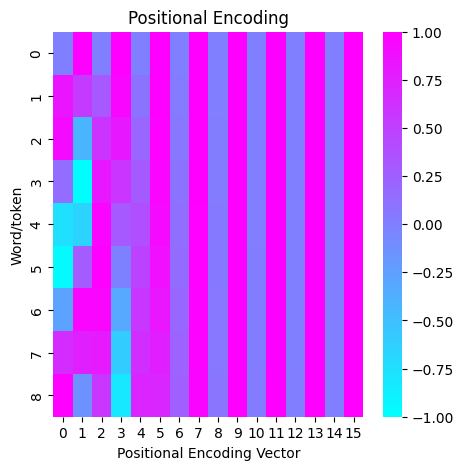

In [150]:
# Function to plot heatmap
# ------------------------
def plot_heatmap(data, title):
    plt.figure(figsize=(5,5))
    seaborn.heatmap(data, cmap="cool",vmin=-1, vmax=1)
    plt.ylabel("Word/token")
    plt.xlabel("Positional Encoding Vector")
    plt.title(title)
    plt.show()

# Generate and plot positional encoding
# -------------------------------------
# Get positional encodings
max_seq_len = len(sentence.split())  # Maximum sequence length
d_model = embedding_size  # Same as the size of the word embeddings
positional_encodings = get_positional_encoding(max_seq_len, d_model)
plot_heatmap(positional_encodings, "Positional Encoding")

## Interpreting the Positional Encoding Map
In the Transformer model, positional encoding is used to give the model some information about the relative positions of the words in the sequence since the Transformer does not have any inherent sense of order of the input sequence.

The positional encoding for a position \(p\) in the sequence and a dimension \(i\) in the embedding space is a mix of sine and cosine functions:


$$PE_{(p, 2i)} = \sin\left(\frac{p}{10000^{2i/d}}\right)$$



$$PE_{(p, 2i+1)} = \cos\left(\frac{p}{10000^{2i/d}}\right)$$


Here, \\(d\\) is the dimension of the word embedding.

These functions were chosen because they can provide a unique encoding for each word position and these encodings can be easily learned and extrapolated for sequence lengths not seen during training.

In the heatmap:

- The x-axis represents the dimension of the embedding space. Every pair of dimensions \\((2i, 2i+1)\\) corresponds to a specific frequency of the sine and cosine functions.

- The y-axis represents the position of a word in the sequence.

- The color at each point in the heatmap represents the value of the positional encoding at that position and dimension. Typically, a warmer color (like red) represents a higher value and a cooler color (like blue) represents a lower value.

By visualizing the positional encodings in a heatmap, we can see how these values change across positions and dimensions, and get an intuition for how the Transformer model might use these values to understand the order of words in the sequence.

In [151]:
# Get positional encodings
max_seq_len = len(sentence.split())  # Maximum sequence length
d_model = embedding_size  # Same as the size of the word embeddings
positional_encodings = get_positional_encoding(max_seq_len, d_model)

# Add word embeddings and positional encodings
final_embeddings = word_embeddings + positional_encodings

print(final_embeddings)

tf.Tensor(
[[-1.9188179e-02  1.0234026e+00 -2.4931801e-02  1.0451899e+00
   3.3188906e-02  1.0285900e+00 -2.3604346e-02  9.6849126e-01
   4.1704658e-02  9.5166725e-01 -4.4394195e-02  1.0199637e+00
   3.9879512e-02  1.0473773e+00 -7.3013306e-03  1.0239735e+00]
 [ 8.2520896e-01  5.7940179e-01  2.8132418e-01  9.3811131e-01
   7.2170101e-02  9.9339879e-01  6.0571503e-02  1.0408387e+00
   6.0712909e-03  1.0075321e+00 -2.6161414e-02  1.0466400e+00
  -4.6065226e-02  9.8935616e-01  1.6288524e-03  1.0214391e+00]
 [ 9.2957687e-01 -4.2476130e-01  5.9470844e-01  8.4477794e-01
   2.3987791e-01  9.8892868e-01  2.5895573e-02  9.9444515e-01
   2.3324676e-03  1.0103543e+00  3.3213329e-02  1.0089599e+00
   4.9705043e-02  1.0288527e+00  1.5947761e-02  9.6045405e-01]
 [ 1.1827322e-01 -1.0252720e+00  8.1076264e-01  6.1556691e-01
   2.4865381e-01  9.9391872e-01  1.3982500e-01  9.6699005e-01
   1.9181907e-02  1.0330529e+00  3.9995927e-02  1.0060281e+00
  -3.3795882e-02  1.0102561e+00 -1.0744414e-02  1.037245

# Section 2: Building Our Own Decoder From Scratch

Let's now build a decoder transformer. We'll build up the code from scratch and build a single layer transformer.

In [152]:
import tensorflow
from tensorflow.keras.layers import MultiHeadAttention ,Dense, LayerNormalization, Dropout ,Embedding,Softmax

In [153]:
# Here we define the DecoderBlock, which is a single layer of the Transformer Decoder.

class DecoderBlock(tf.keras.Model):
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout):
        super(DecoderBlock, self).__init__()

    # The first part of the __init__ function defines the hyperparameters for the DecoderBlock.
    # d_model: the dimension of the input vector.
    # num_heads: the number of heads in the multihead attention mechanism.
    # ff_hidden_dim: the dimension of the feed forward hidden layer.
    # dropout: the dropout rate.

        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.norm1 = LayerNormalization(d_model)
        self.dropout1 = Dropout(dropout)
        self.linear1 = Dense(ff_hidden_dim)
        self.linear2 = Dense(d_model)
        self.norm2 = LayerNormalization(d_model)
        self.dropout2 = Dropout(dropout)

    # The forward method defines how the data flows through the network.
    # It takes two inputs: x, tgt_mask.
    # x: the input tensor.
    # tgt_mask: masks to prevent attention to certain positions.

    # def call(self,x,tgt_mask):
    #     print('01-sa')
    #     #y= tf.transpose(x, perm=[1, 0, 2])

    #     print(x.shape)
    #     print(tgt_mask.shape)
    #     print('02-sam')
    #     attn_output , _= self.self_attention(x, x, x, attention_mask=tgt_mask)
    #     print('hello')
    #     print('1')
    #     print(attn_output)

    #     x = x + self.dropout1(attn_output)
    #     print('2')

    #     x = self.norm1(x)
    #     print('3')
    #     ff_output = self.linear2(self.linear1(x),"relu")
    #     print('hi')
    #     x = x + self.dropout2(ff_output)
    #     x = self.norm2(x)
    #     return x

    def call(self, x, tgt_mask):
        print('01-sa')
        # Print shapes for debugging
        print("x shape:", x.shape)
        print("tgt_mask shape:", tgt_mask.shape)

        
        x= tf.transpose(x, perm=[1, 0, 2])

        print("y shape:", x.shape)
        
        # Apply self-attention mechanism
        attn_output, _ = self.self_attention(query=x, value=x, key=x, attention_mask=tgt_mask)
        print('hello')

        # Apply dropout and residual connection
        x = x + self.dropout1(attn_output)

        # Apply layer normalization
        x = self.norm1(x)

        # Apply feed-forward layer
        ff_output = self.linear2(self.linear1(x))
        print('hi')

        # Apply dropout and residual connection
        x = x + self.dropout2(ff_output)

        # Apply layer normalization
        x = self.norm2(x)

        return x

In [154]:
# Next, we define the PositionalEncoding class, which applies a specific positional encoding to give the model 
# information about the relative or absolute position of the tokens in the sequence.

class PositionalEncoding(tf.keras.Model):
#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = Dropout(dropout)

#         pe = tf.zeros([max_len, d_model],dtype=float)
#         position = tf.range(0, max_len, dtype=float)
#         position = tf.expand_dims(position, axis=1)
#         div_term = tf.exp(tf.range(0, d_model, 2,dtype=float) * (-math.log(10000.0) / d_model))
#         sin_values = tf.sin(position * div_term)
#         cos_values = tf.cos(position * div_term)

# # Assign sine values to even indices and cosine values to odd indices
#         pe = tf.concat([sin_values[:, ::2], cos_values[:, 1::2]], axis=1)   
#         pe = tf.transpose(tf.expand_dims(pe, axis=0))
#         self.pe = tf.Variable(pe, trainable=False)

#     def call(self, x):
#         print('y')
#         print(x)
#         x = x + self.pe[:tf.shape(x)[0], :]
#         print('n')
#         return self.dropout(x)

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = tf.keras.layers.Dropout(dropout)

        position = tf.range(0, max_len, dtype=tf.float32)
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * (-math.log(10000.0) / d_model))
        pe = tf.sin(position[:, tf.newaxis] * div_term)
        pe = tf.concat([pe[:, :, tf.newaxis], pe[:, :, tf.newaxis]], axis=-1)  # Duplicate for even and odd indices
        pe = tf.reshape(pe, (1, max_len, d_model))  # Add batch dimension
        self.pe = tf.Variable(pe, trainable=False, dtype=tf.float32)  # Make it a trainable variable

    def call(self, inputs):
        x = inputs + self.pe[:, :tf.shape(inputs)[1], :]
        return self.dropout(x)

In [155]:
# Finally, we define the full Transformer Decoder, which includes the initial embedding layer, 
# a single Transformer Decoder block, and the final linear and softmax layers.

class TransformerDecoder(tf.keras.Model):
    def __init__(self, vocab_size, d_model, num_heads, ff_hidden_dim, dropout):
        super(TransformerDecoder, self).__init__()

    # The __init__ function defines the hyperparameters and layers of the TransformerDecoder.
    # vocab_size: the size of the vocabulary.
    # d_model, num_heads, ff_hidden_dim, dropout: hyperparameters for the Transformer decoder block.

    # Embedding layer: transforms the input words (given as indices) into dense vectors of dimension d_model.
    # Positional encoding: adds a vector to each input embedding that depends on its position in the sequence.
    # Transformer block: the Transformer decoder block defined earlier.
    # Linear layer: a linear transformation to the output dimension equal to the vocabulary size.
    # Softmax layer: transforms the output into a probability distribution over the vocabulary.

        self.embedding = Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_block = DecoderBlock(d_model, num_heads, ff_hidden_dim, dropout)
        self.linear = Dense(vocab_size)
        #self.softmax = Softmax(dim=-1)
        self.softmax = tf.keras.layers.Lambda(lambda x: tf.nn.log_softmax(x, axis=-1))
        print('hello')

    # The forward method of the TransformerDecoder defines how the data flows through the decoder.

    def call(self, x,training=False):
        x = self.embedding(x)
        print('after embedding')
        print(x.shape)
        x = self.pos_encoder(x)
        print('after pos encoding')
        print(x.shape)
        tgt_mask = generate_square_subsequent_mask(tf.shape(x)[0])
        print('sat')
        print(tgt_mask)
        x = self.transformer_block(x,tgt_mask)
        output = self.linear(x)
        output = self.softmax(output)
        print('hello')
        print(output)
        return output

### Why we need to mask our input for decoders

In [156]:
def generate_square_subsequent_mask(sz):
    """Generate a mask to prevent attention to future positions."""
    mask = tf.transpose(tf.linalg.band_part(tf.ones((sz, sz)), 0, -1))
    #mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask = tf.cast(mask, dtype=tf.float32)

# Apply a mask to set certain values
    mask = tf.where(mask == 0, float('-inf'), mask)
    mask = tf.where(mask == 1, 0.0, mask)
    mask = tf.expand_dims(mask,axis=1)
    return mask

mask = generate_square_subsequent_mask(sz=5)
print(mask)

# plt.figure(figsize=(5,5))
# seaborn.heatmap(mask, cmap="viridis", cbar=False, square=True)
# plt.title("Mask for Transformer Decoder")
# plt.show()

tf.Tensor(
[[[  0. -inf -inf -inf -inf]
  [  0.   0. -inf -inf -inf]
  [  0.   0.   0. -inf -inf]
  [  0.   0.   0.   0. -inf]
  [  0.   0.   0.   0.   0.]]], shape=(1, 5, 5), dtype=float32)


### Let's make our first decoder

In [157]:
# Define the hyperparameters
vocab_size     = 1000
d_model        = 512
num_heads      = 1
ff_hidden_dim  = 2*d_model
dropout        = 0.1
num_layers     = 10
context_length = 50
batch_size     = 1
# Initialize the model
model = TransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout)

# Create a tensor representing a batch of 1 sequences of length 10
input_tensor = tf.random.uniform((context_length, batch_size), minval=0, maxval=vocab_size, dtype=tf.float32)
print(input_tensor.shape)

print('name')

print(model.summary())

# # Forward pass through the model
output = model(input_tensor)


# # The output is a tensor of shape (sequence_length, batch_size, vocab_size)
# print(output.shape)  # Should print torch.Size([context_length, batch_size, vocab_size])

# # To get the predicted word indices, we can use the `argmax` function
# predicted_indices = output.argmax(dim=-1)

# # Now `predicted_indices` is a tensor of shape (sequence_length, batch_size) containing the predicted word indices
# print(predicted_indices.shape)  # Should print torch.Size([context_length, batch_size])


hello
(50, 1)
name


Model: "transformer_decoder_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_11          │ ?                      │   0 (unbuilt) │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_11 (DecoderBlock) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
after embedding
(50, 1, 512)
after pos encoding
(50, 1, 512)
sat
Tensor("ExpandDims:0", shape=(1, 50, 50), dtype=float32)
01-sa
x shape: (50, 1, 512)
tgt_mask shape: (1, 50, 50)
y shape: (1, 50, 512)
01-sa
x shape: (50, 1, 512)
tgt_mask shape: (1, 50, 50)
y shape: (1, 50, 512)
after embedding
(50, 1, 512)
after pos encoding
(50, 1, 512)
sat
tf.Tensor(
[[[  0. -inf -inf ... -inf -inf -inf]
  [  0.   0. -inf ... -inf -inf -inf]
  [  0.   0.   0. ... -inf -inf -inf]
  ...
  [  0.   0.   0. ...   0. -inf -inf]
  [  0.   0.   0. ...   0.   0. -inf]
  [  0.   0.   0. ...   0.   0.   0.]]], shape=(1, 50, 50), dtype=float32)
01-sa
x shape: (50, 1, 512)
tgt_mask shape: (1, 50, 50)
y shape: (1, 50, 512)
01-sa
x shape: (50, 1, 512)
tgt_mask shape: (1, 50, 50)
y shape: (1, 50, 512)


ValueError: Exception encountered when calling DecoderBlock.call().

[1mnot enough values to unpack (expected 2, got 1)[0m

Arguments received by DecoderBlock.call():
  • x=tf.Tensor(shape=(50, 1, 512), dtype=float32)
  • tgt_mask=tf.Tensor(shape=(1, 50, 50), dtype=float32)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

### Looking at the output

In [ ]:
# Convert the log probabilities to probabilities
distribution = torch.exp(output[0, 0, :])

# Convert the output tensor to numpy array
distribution = distribution.detach().numpy()

# Now plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel("Word Index")
plt.ylabel("Probability")
plt.title("Output Distribution over Vocabulary")
plt.show()

# Section 3: Multi-layer Decoder

Let's allow for multiple layers in our decoder so we can form models like GPT

In [ ]:
class MultiLayerTransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers):
        super(MultiLayerTransformerDecoder, self).__init__()

# The __init__ function now also takes a `num_layers` argument, which specifies the number of decoder blocks.

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, ff_hidden_dim, dropout)
            for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

# The forward method has been updated to pass the input through each transformer block in sequence.

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        for transformer_block in self.transformer_blocks:
            tgt_mask = generate_square_subsequent_mask(x.size(0))
            x = transformer_block(x,tgt_mask)
        output = self.linear(x)
        output = self.softmax(output)
        return output


In [ ]:
# Define the hyperparameters
vocab_size     = 10000
d_model        = 2048
num_heads      = 1
ff_hidden_dim  = 4*d_model
dropout        = 0.1
num_layers     = 10
context_length = 100
batch_size     = 1

# Create our input to the model to process
input_tensor = torch.randint(0, vocab_size, (context_length, batch_size))

# Initialize the model with `num_layer` layers
model = MultiLayerTransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers)

# Print the number of trainable parameters
print(f"The model has {count_parameters(model):,} trainable parameters")

# Let's use the same input_tensor from the previous example
output = model(input_tensor)

# Convert the log probabilities to probabilities for the first sequence in the batch and the first position in the sequence
distribution = torch.exp(output[0, 0, :])

# Convert the output tensor to numpy array
distribution = distribution.detach().numpy()

# Now plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel("Word Index")
plt.ylabel("Probability")
plt.title("Output Distribution over Vocabulary")
plt.show()

In [ ]:
model

# Section 4: Adding real vocabulary to our model

Rather than just using a random integer, let's add in a small vocabulary of real words and let our model speak!

In [ ]:
# Define the hyperparameters
d_model        = 100
num_heads      = 1
ff_hidden_dim  = 4*d_model
dropout        = 0.1
num_layers     = 4
context_length = 5
batch_size     = 1
# Define the vocabulary
vocab = ["of", "in", "to", "for", "with", "on", "at", "from", "by", "about", "as", "into", "like", "through", "after", "over", "between", "out", "against", "during", "without", "before", "under", "around", "among"]
vocab_size = len(vocab)

# Create a dictionary that maps words to indices
word2id = {word: id for id, word in enumerate(vocab)}

# Create a dictionary that maps indices to words
id2word = {id: word for id, word in enumerate(vocab)}

# Initialize the model
model = MultiLayerTransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers)

# Create a tensor representing a single sequence of variable length
# Here we randomly select words from our vocabulary
sequence = ["of", "in", "to", "for", "with", "on", "at"][:context_length]
input_tensor = torch.tensor([[word2id[word] for word in sequence]])

# Generate a sequence of words
generated_words = []
for i in range(10):  # Generate 10 words
    output = model(input_tensor)
    predicted_index = output.argmax(dim=-1)[0, -1]  # Take the last word in the sequence
    predicted_word = id2word[predicted_index.item()]
    print(predicted_word, end=" ")
    generated_words.append(predicted_word)
    input_tensor = torch.cat([input_tensor, predicted_index.unsqueeze(0).unsqueeze(0)], dim=-1)  # Append the predicted word to the input
    time.sleep(0.75)  # Pause for 1 second


# Section 5: Using a trained decoder and real-world vocabulary

Training our model will take a long time, let's look at two trained versions of what we've been building, GPT and GPT-XL. These are both decoder models with only slight changes in sizes

In [ ]:
# Import the necessary libraries
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained models and tokenizers
tokenizer_small = GPT2Tokenizer.from_pretrained("gpt2", cache_dir=DA.paths.datasets+"/models")
model_small = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=DA.paths.datasets+"/models")

In [ ]:
# Define a prompt. This is the initial string of text that the model will use to start generating text.
prompt = "This is a MOOC about large language models, I have only just started, but already"

In [ ]:
# We use the tokenizer to convert the prompt into a format that the model can understand. In this case,
# it converts the string into a sequence of token IDs, which are numbers that represent each word or subword in the string.
inputs_small = tokenizer_small.encode(prompt, return_tensors='pt')

# Create an attention mask. This is a sequence of 1s and 0s where 1s indicate that the corresponding token should
# be attended to and 0s indicate that the token should be ignored. Here, all tokens should be attended to.
attention_mask_small = torch.ones(inputs_small.shape, dtype=torch.long)

# Get the ID of the special end-of-sequence (EOS) token from the tokenizer. This token indicates the end of a sequence.
pad_token_id_small = tokenizer_small.eos_token_id  

# Print the initial prompt. The 'end' argument specifies what to print at the end (default is newline, but we want space).
# 'flush' argument ensures that the output is printed immediately.
print(prompt, end=" ", flush=True)

# We're going to generate 25 words
for _ in range(25):

    # Generate the next part of the sequence. 'do_sample=True' means to sample from the distribution of possible next tokens
    # rather than just taking the most likely next token. 'pad_token_id' argument is to tell the model what token to use if it
    # needs to pad the sequence to a certain length.
    outputs_small = model_small.generate(inputs_small, max_length=inputs_small.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_small,
                                         attention_mask=attention_mask_small)

    # The generated output is a sequence of token IDs, so we use the tokenizer to convert these back into words.
    generated_word = tokenizer_small.decode(outputs_small[0][-1])

    # Print the generated word, followed by a space. We use 'end' and 'flush' arguments as before.
    print(generated_word, end=' ', flush=True)

    # Append the generated token to the input sequence for the next round of generation. We have to add extra dimensions 
    # to the tensor to match the shape of the input tensor (which is 2D: batch size x sequence length).
    inputs_small = torch.cat([inputs_small, outputs_small[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1)

    # Extend the attention mask for the new token. Like before, it should be attended to, so we add a 1.
    attention_mask_small = torch.cat([attention_mask_small, torch.ones((1, 1), dtype=torch.long)], dim=-1)

    # We pause for 0.7 seconds to make the generation more readable.
    time.sleep(0.7)

# Finally, print a newline and a completion message.
print("\nGPT-2 Small completed.")

In [ ]:
tokenizer_large = GPT2Tokenizer.from_pretrained("gpt2-XL", cache_dir=DA.paths.datasets+"/models")
model_large = GPT2LMHeadModel.from_pretrained("gpt2-XL", cache_dir=DA.paths.datasets+"/models")

In [ ]:
# Generate text with GPT-2 XL
inputs_large = tokenizer_large.encode(prompt, return_tensors="pt")

# Add in the attention mask and pad token id
attention_mask_large = torch.ones(inputs_large.shape, dtype=torch.long)  # Creating a mask of ones with the same shape as inputs
pad_token_id_large = tokenizer_large.eos_token_id  # Get the eos_token_id from the tokenizer

print(prompt, end=" ", flush=True)
for _ in range(25):  # Generate 25 words
    outputs_large = model_large.generate(inputs_large, max_length=inputs_large.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_large,
                                         attention_mask=attention_mask_large)
    generated_word = tokenizer_large.decode(outputs_large[0][-1])
    print(generated_word, end=" ", flush=True)
    inputs_large = torch.cat([inputs_large, outputs_large[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1)
    attention_mask_large = torch.cat([attention_mask_large, torch.ones((1, 1), dtype=torch.long)], dim=-1)
    time.sleep(0.7)
print("\nGPT-2 XL completed.")

&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>